# **DATASET AND PREPROCESSING**

**Import Libraries**

In [411]:
import os
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
random.seed(11)
np.random.seed(11)


**Download & Unzipping Dataset from GitHub and Setting Up the Dataset Path**

In [412]:
# Dataset path
dataset_path = "./animal_dataset"

# Check if folder already exists
if not os.path.exists(dataset_path):
    print("Dataset not found. Downloading now...")

    !wget -O animal_dataset.zip "https://github.com/mostafa-galib/CVPR/raw/main/MID/animal_dataset.zip"
    !unzip -q animal_dataset.zip -d .

    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists. Skipping download.")

Dataset already exists. Skipping download.


**Get Class Names and Count Images in Each Class**

In [413]:
class_names = sorted(os.listdir(dataset_path))
print("Classes found:", class_names)

img_count = {}

for cname in class_names:
    folder = os.path.join(dataset_path, cname)
    img_count[cname] = len(os.listdir(folder))

print("\nImages per class:", img_count)
print("Total images:", sum(img_count.values()))


Classes found: ['cat', 'dog', 'panda']

Images per class: {'cat': 100, 'dog': 100, 'panda': 100}
Total images: 300


**Show Original Samples**

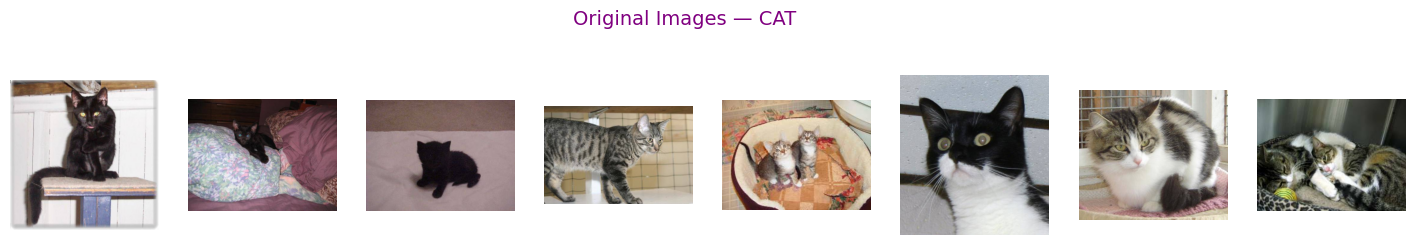

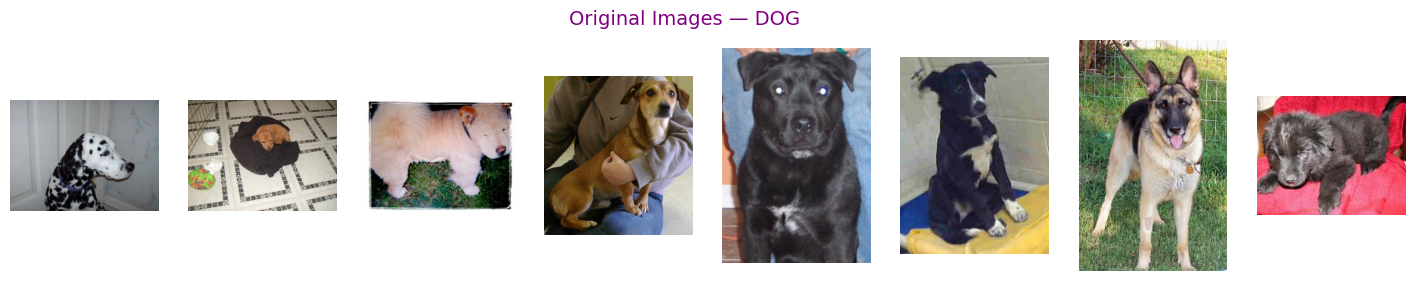

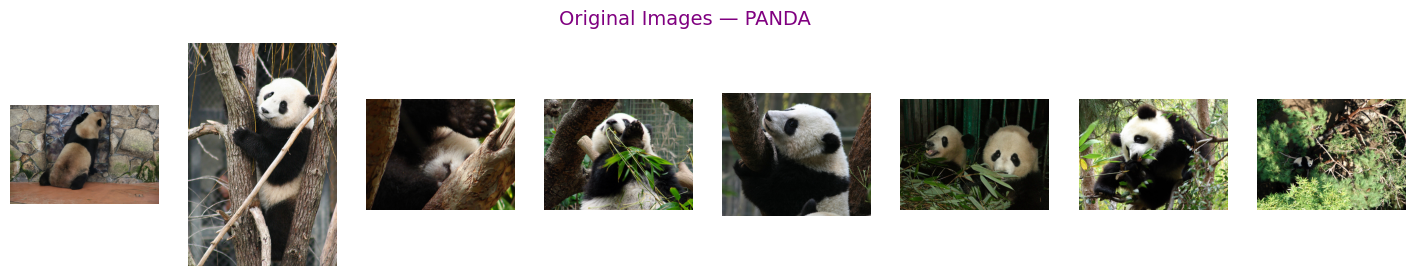

In [414]:
def preview_class_samples(label, n=8):
    folder = os.path.join(dataset_path, label)
    imgs = os.listdir(folder)[:n]

    plt.figure(figsize=(18,3))
    for i, fname in enumerate(imgs):
        path = os.path.join(folder, fname)
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")

    plt.suptitle(f"Original Images — {label.upper()}", fontsize=14, color='purple')
    plt.show()

for c in class_names:
    preview_class_samples(c)


**Load All Images from the Dataset and Convert Them Into Grayscale (32x32)**

In [415]:
image_size = 32

X = []   # to store flattened grayscale images
y = []   # to store class labels

for label, cls in enumerate(class_names):
    class_path = os.path.join(dataset_path, cls)
    image_files = os.listdir(class_path)

    print(f"Processing class: {cls}  -> label = {label}")

    for img_name in image_files:

        # Only process image formats
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        img_path = os.path.join(class_path, img_name)

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            print("Skipping unreadable file:", img_path)
            continue

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Resize to 32x32
        gray_resized = cv2.resize(gray, (image_size, image_size))

        # Flatten to 1D vector (32*32 = 1024)
        flat = gray_resized.flatten()

        # Append to the dataset
        X.append(flat)
        y.append(label)

# Convert lists to numpy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print("Preprocessing completed.")
print("X shape (samples, features):", X.shape)
print("y shape (labels):", y.shape)
print("First 10 labels:", y[:10])

X = X / 255.0 # NORMALIZE PIXELS (0-1 range)
print("Min pixel value:", X.min())
print("Max pixel value:", X.max())

Processing class: cat  -> label = 0
Processing class: dog  -> label = 1
Processing class: panda  -> label = 2
Preprocessing completed.
X shape (samples, features): (300, 1024)
y shape (labels): (300,)
First 10 labels: [0 0 0 0 0 0 0 0 0 0]
Min pixel value: 0.0
Max pixel value: 1.0


**Show Random Preprocessed Grayscale Images**

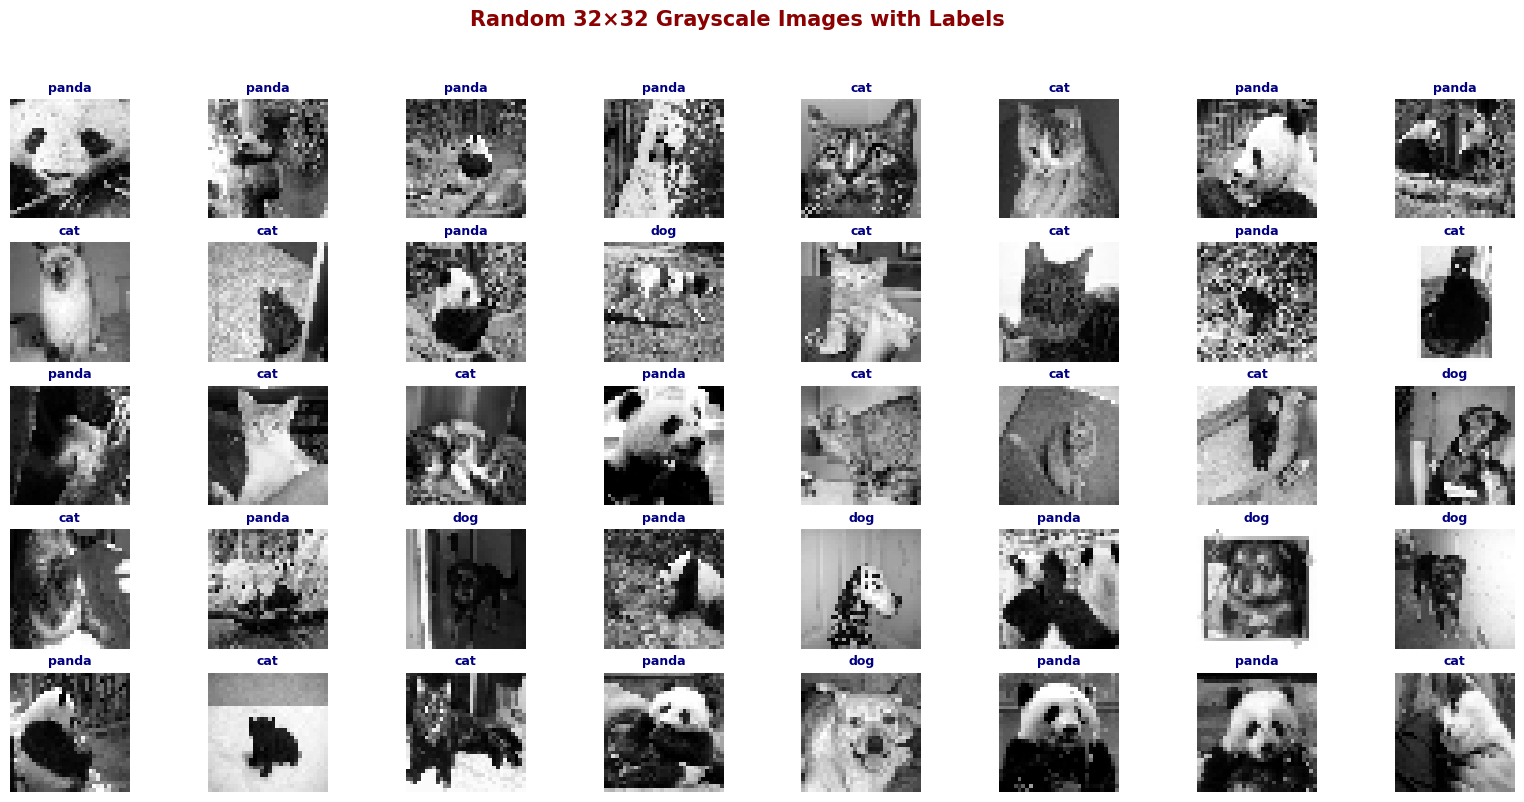

In [416]:
num_preview = 40
random_indexes = random.sample(range(len(X)), num_preview)

plt.figure(figsize=(20, 9))
for i, idx in enumerate(random_indexes):
    img = X[idx].reshape(32, 32)
    plt.subplot(5, 8, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(class_names[y[idx]], fontsize=9, fontweight='bold', color='navy')
    plt.axis('off')

plt.suptitle("Random 32×32 Grayscale Images with Labels", fontsize=15, fontweight='bold', color='darkred')
plt.show()



**Combine Features Labels Into One List**

In [417]:
# Combine flattened features and labels
dataset_pairs = list(zip(X, y))    # X = features, y = labels
random.shuffle(dataset_pairs)      # shuffle so folds are random

print("Dataset combined and shuffled.")


Dataset combined and shuffled.


# **MODEL BUILDING AND EVALUTATION**

**Create 5 Folds**

In [418]:
num_folds = 5
fold_len = len(dataset_pairs) // num_folds

fold_list = [ dataset_pairs[i*fold_len : (i+1)*fold_len] for i in range(num_folds) ]

print("\nFold sizes:")
for i, f in enumerate(fold_list):
    print(f" Fold {i+1}: {len(f)} samples")


Fold sizes:
 Fold 1: 60 samples
 Fold 2: 60 samples
 Fold 3: 60 samples
 Fold 4: 60 samples
 Fold 5: 60 samples


**DISTANCE FUNCTIONS**

In [419]:
def manhattan_distance(a, b):
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


In [420]:
# Test distance between two different images
d_l1 = manhattan_distance(X[0], X[1])
d_l2 = euclidean_distance(X[0], X[1])

print(f"Test L1 distance between image 0 and 1: {d_l1:.4f}")
print(f"Test L2 distance between image 0 and 1: {d_l2:.4f}")

# Test distance between the same image (should be 0)
same_image_d1 = manhattan_distance(X[10], X[10])
same_image_d2 = euclidean_distance(X[20], X[20])

print(f"Test L1 distance of same feature/image: {same_image_d1:.4f}")
print(f"Test L2 distance of same feature/image: {same_image_d2:.4f}")


Test L1 distance between image 0 and 1: 389.5255
Test L2 distance between image 0 and 1: 14.2846
Test L1 distance of same feature/image: 0.0000
Test L2 distance of same feature/image: 0.0000


**k-NN Classifier**

In [421]:
def knn_predict(X_train, y_train, x_test, k=5, distance_type='l2'):
    distances = []  # to store (distance, label)

    # Compute distance between test sample and all training samples
    for i in range(len(X_train)):
        if distance_type == 'l1':
            d = manhattan_distance(X_train[i], x_test)
        else:
            d = euclidean_distance(X_train[i], x_test)
        distances.append((d, y_train[i]))

    # Sort by distance (small → big)
    distances.sort(key=lambda x: x[0])

    # Take first k labels
    k_labels = [label for _, label in distances[:k]]

    # Count which label appears the most (majority voting)
    label_count = {}
    for label in k_labels:
        label_count[label] = label_count.get(label, 0) + 1

    # Return the label with the highest vote
    return max(label_count, key=label_count.get)

**5-Fold Cross Validation for k-NN**

In [422]:
def run_knn_cv(folds, k_values, distance_type='l2'):
    fold_accuracies = []

    for fold_idx in range(len(folds)):

        # 1. Select validation fold
        val_data = folds[fold_idx]

        # 2. Combine the other 4 folds into training data
        train_data = []
        for i in range(len(folds)):
            if i != fold_idx:
                train_data.extend(folds[i])

        # Separate features and labels
        X_train = np.array([item[0] for item in train_data])
        y_train = np.array([item[1] for item in train_data])
        X_val   = np.array([item[0] for item in val_data])
        y_val   = np.array([item[1] for item in val_data])

        # Store accuracies for this fold
        fold_acc = []

        for k in k_values:
            correct = 0

            for j in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[j], k=k, distance_type=distance_type)
                if pred == y_val[j]:
                    correct += 1

            accuracy = correct / len(X_val)
            fold_acc.append(accuracy)

        fold_accuracies.append(fold_acc)
        print(f"Fold {fold_idx+1}/5 completed")

    # Average accuracy across 5 folds
    avg_accuracy = np.mean(fold_accuracies, axis=0)
    return fold_accuracies, avg_accuracy

**Run Cross-Validation for Multiple K Values (L1 and L2)**

In [423]:
K_values = np.arange(1, 13)

print("--- Running Manhattan (L1) ---")
fold_acc_l1, avg_acc_l1 = run_knn_cv(fold_list, K_values, distance_type='l1')

print("--- Running Euclidean (L2) ---")
fold_acc_l2, avg_acc_l2 = run_knn_cv(fold_list, K_values, distance_type='l2')


--- Running Manhattan (L1) ---
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed
Fold 5/5 completed
--- Running Euclidean (L2) ---
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed
Fold 5/5 completed


# **RESULT AND ANALYSIS**

**PLOT RESULTS FOR EACH FOLD (L1 & L2)**

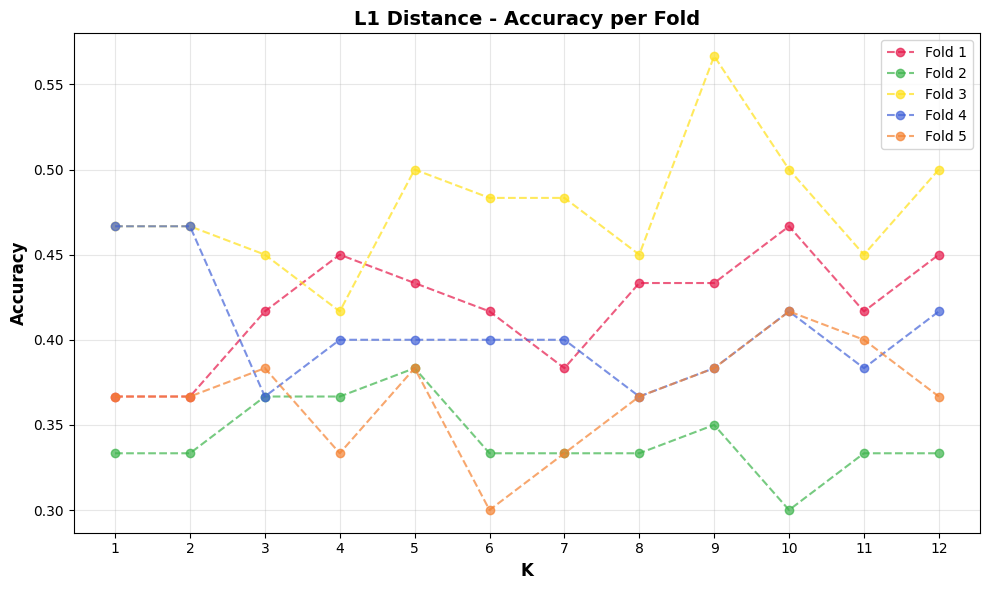

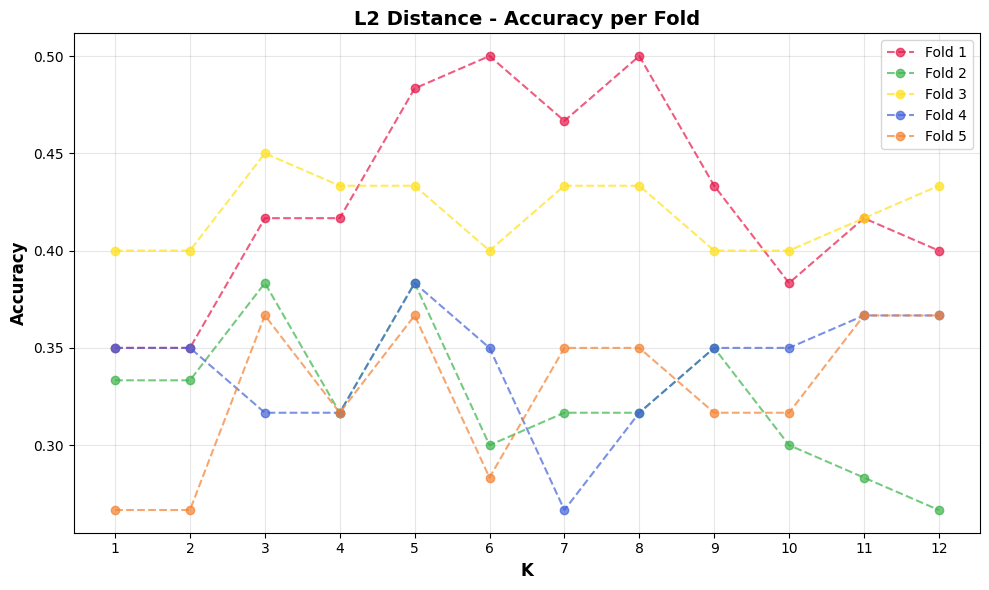

In [424]:
# PLOT ACCURACY OF EACH FOLD FOR L1 DISTANCE
fold_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

plt.figure(figsize=(10, 6))
for i, acc in enumerate(fold_acc_l1):
    plt.plot(K_values, acc, 'o--', color=fold_colors[i], alpha=0.7,
             linewidth=1.5, markersize=6, label=f'Fold {i+1}')

plt.xlabel('K', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('L1 Distance - Accuracy per Fold', fontsize=14, fontweight='bold')
plt.xticks(K_values)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# PLOT ACCURACY OF EACH FOLD FOR L2 DISTANCE
plt.figure(figsize=(10, 6))
for i, acc in enumerate(fold_acc_l2):
    plt.plot(K_values, acc, 'o--', color=fold_colors[i], alpha=0.7,
             linewidth=1.5, markersize=6, label=f'Fold {i+1}')

plt.xlabel('K', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('L2 Distance - Accuracy per Fold', fontsize=14, fontweight='bold')
plt.xticks(K_values)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


**PLOT AVERAGE ACCURACY FOR L1 vs L2 (MAIN GRAPH)**

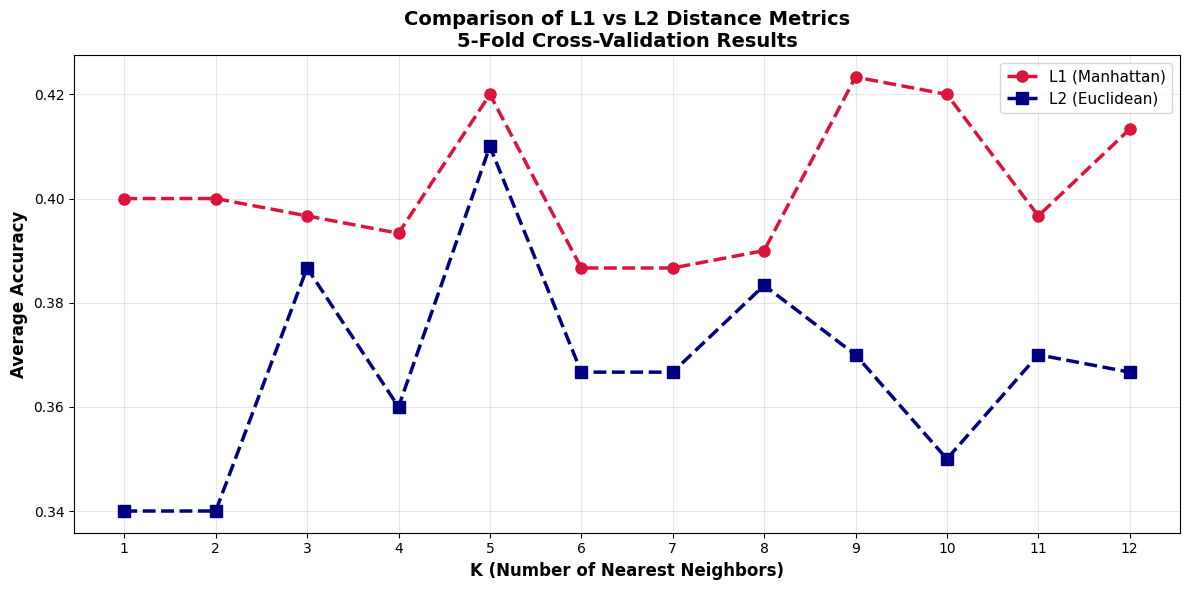

In [425]:
# **PLOT L1 vs L2 AVERAGE ACCURACY COMPARISON**

plt.figure(figsize=(12, 6))

plt.plot(K_values, avg_acc_l1, 'o--', color='crimson', linewidth=2.5,
         markersize=8, label='L1 (Manhattan)')
plt.plot(K_values, avg_acc_l2, 's--', color='navy', linewidth=2.5,
         markersize=8, label='L2 (Euclidean)')

plt.xlabel('K (Number of Nearest Neighbors)', fontsize=12, fontweight='bold')
plt.ylabel('Average Accuracy', fontsize=12, fontweight='bold')
plt.title('Comparison of L1 vs L2 Distance Metrics\n5-Fold Cross-Validation Results',
          fontsize=14, fontweight='bold')

plt.xticks(K_values)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()



**PRINT AVERAGE ACCURACY FOR EACH K (L1 and L2)**

In [426]:
print("K   |   L1 Accuracy (%)   |   L2 Accuracy (%)")
print("---------------------------------------------")

for k, acc1, acc2 in zip(K_values, avg_acc_l1, avg_acc_l2):
    print(f"{k:2d}  |     {acc1*100:6.2f}%       |      {acc2*100:6.2f}%")


K   |   L1 Accuracy (%)   |   L2 Accuracy (%)
---------------------------------------------
 1  |      40.00%       |       34.00%
 2  |      40.00%       |       34.00%
 3  |      39.67%       |       38.67%
 4  |      39.33%       |       36.00%
 5  |      42.00%       |       41.00%
 6  |      38.67%       |       36.67%
 7  |      38.67%       |       36.67%
 8  |      39.00%       |       38.33%
 9  |      42.33%       |       37.00%
10  |      42.00%       |       35.00%
11  |      39.67%       |       37.00%
12  |      41.33%       |       36.67%


**FIND THE BEST K AND BEST METRIC (L1 or L2)**

In [427]:
best_k_l1 = K_values[np.argmax(avg_acc_l1)]
best_acc_l1 = max(avg_acc_l1)

best_k_l2 = K_values[np.argmax(avg_acc_l2)]
best_acc_l2 = max(avg_acc_l2)

print("\nBEST RESULTS:")
print(f"Manhattan (L1): Best K = {best_k_l1},  Accuracy = {best_acc_l1*100:.2f}%")
print(f"Euclidean (L2): Best K = {best_k_l2},  Accuracy = {best_acc_l2*100:.2f}%")

if best_acc_l1 > best_acc_l2:
    final_metric = 'l1'
    final_k = best_k_l1
else:
    final_metric = 'l2'
    final_k = best_k_l2

print(f"\nWINNER: Using {final_metric.upper()} distance with K = {final_k}")



BEST RESULTS:
Manhattan (L1): Best K = 9,  Accuracy = 42.33%
Euclidean (L2): Best K = 5,  Accuracy = 41.00%

WINNER: Using L1 distance with K = 9


**TOP 5 PREDICTIONS**


Using best configuration: Distance = L1, K = 9


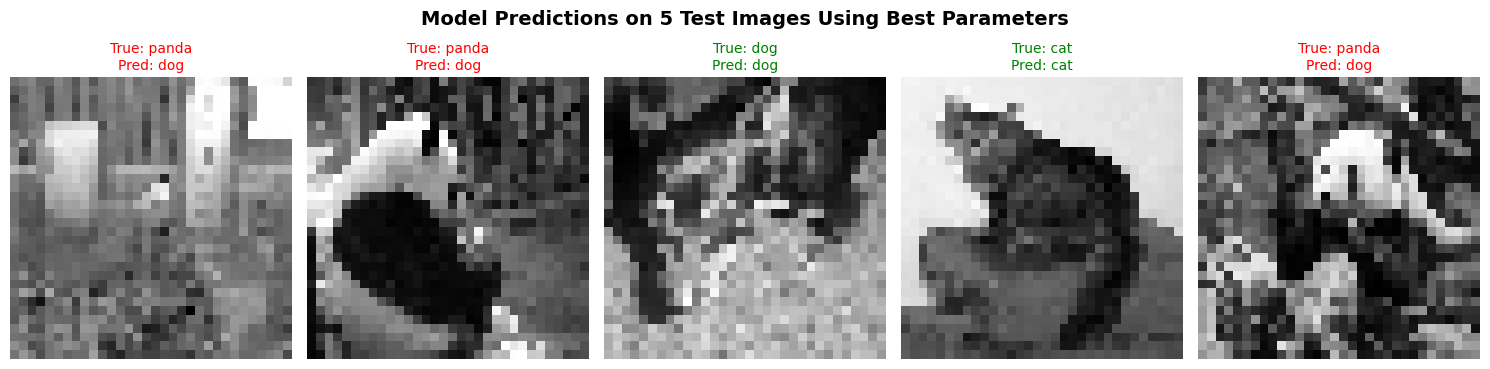

Correctly Predicted: 2/5
Accuracy Achieved: 40.00%


In [428]:
# Use the best performing metric and K found earlier
best_metric = 'l2' if best_acc_l2 > best_acc_l1 else 'l1'
best_k = best_k_l2 if best_acc_l2 > best_acc_l1 else best_k_l1

print(f"\nUsing best configuration: Distance = {best_metric.upper()}, K = {best_k}")

test_data = fold_list[0]     # first fold = test set
train_data = []

for i in range(1, 5):         # remaining folds = training set
    train_data.extend(fold_list[i])

# build numpy arrays
X_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])

# Show 5 predictions
num_show = 5
fig, axes = plt.subplots(1, num_show, figsize=(15, 4))

correct = 0

for i in range(num_show):

    x_test, y_true = test_data[i]

    y_pred = knn_predict(
        X_train, y_train,
        x_test,
        k=best_k,
        distance_type=best_metric
    )

    # correct or incorrect
    color = 'green' if y_pred == y_true else 'red'
    if y_pred == y_true:
        correct += 1

    axes[i].imshow(x_test.reshape(32, 32), cmap='gray')

    axes[i].set_title(
        f"True: {class_names[y_true]}\nPred: {class_names[y_pred]}",
        color=color,
        fontsize=10
    )

    axes[i].axis('off')

plt.suptitle(
    "Model Predictions on 5 Test Images Using Best Parameters",
    fontsize=14, fontweight='bold'
)
plt.tight_layout()
plt.show()

print(f"Correctly Predicted: {correct}/{num_show}")
print(f"Accuracy Achieved: {(correct/num_show)*100:.2f}%")


# **DISCUSSION**

In this experiment, we compared the performance of the Manhattan (L1) distance and Euclidean (L2) distance for classifying gray-scale animal images using a k-Nearest Neighbors (k-NN) classifier. The evaluation was carried out using 5-fold cross-validation, and the average accuracy for each value of K was recorded.

# Overall Performance Comparison

From the results table, Manhattan (L1) produced slightly better accuracy than Euclidean (L2) for almost every value of K.

Best L1 accuracy: 42.33% at K = 9 and Best L2 accuracy: 41.00% at K = 5

Although the difference is small, L1 consistently outperformed L2, making Manhattan distance the better choice for this dataset.

# There are several reasons why L1 may work better on this dataset:

* Sensitive to small pixel differences: The images are converted to 32×32 grayscale, meaning each image has 1024 pixel values. L1 handles high-dimensional, sparse differences better because it adds absolute differences, not squared differences.

* Noise tolerance: Some images in the dataset may contain lighting variations or small grayscale noise. L1 is less sensitive to outliers because it does not square the differences like L2.

* Low-resolution dataset: Since each image is downsampled to 32x32, lot of details are lost. L1 often performs better in such low-detail situations.

# Dataset Characteristics Affecting Accuracy

Each class (cat, dog, panda) has only 100 images, which is a small dataset for image classification. Converting to 32×32 grayscale removes texture and color information, making the classes harder to separate. Many animals share similar shapes at low resolution → leads to misclassification.

# Limitations

*   Small dataset
*   No feature extraction
*   No image augmentation
*   k-NN is computationally simple, it cannot learn deeper patterns like CNNs.

# Possible Improvements

*   Use feature extraction techniques such as PCA
*   Increase image size (maybe 64×64 instead of 32×32)
*   Use color images instead of grayscale
*   Try different classifiers